# Modeling ingredients recommender

The goal of this notebook is to prepare the datasets that we will use to train the Machine Learning Model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

%matplotlib inline

# pd.set_option('display.float_format', lambda x: '%.2f' % x)

### 1.1 Import and subset

In [2]:
reviews_ingredient = pd.read_pickle('data/to_sql/interactions_recipes_raw.pkl')

In [3]:
reviews_ingredient.shape

(3794003, 4)

In [4]:
subset = reviews_ingredient[:50000].drop('Unnamed: 0', errors='ignore')

In [5]:
subset.head()

,user_id,recipe_id,rating,ingredients
0,8542392,222388,5,"[pork belly, smoked paprika, kosher salt, grou..."
1,11174581,222388,5,"[pork belly, smoked paprika, kosher salt, grou..."
2,8262477,222388,5,"[pork belly, smoked paprika, kosher salt, grou..."
3,3574785,240488,5,"[sauerkraut drained, Granny Smith apples slice..."
4,12145410,240488,2,"[sauerkraut drained, Granny Smith apples slice..."


In [6]:
# Convert ingredients column to list type
subset = subset.explode('ingredients')

In [7]:
subset.head(10)

,user_id,recipe_id,rating,ingredients
0,8542392,222388,5,pork belly
0,8542392,222388,5,smoked paprika
0,8542392,222388,5,kosher salt
0,8542392,222388,5,ground black pepper
1,11174581,222388,5,pork belly
1,11174581,222388,5,smoked paprika
1,11174581,222388,5,kosher salt
1,11174581,222388,5,ground black pepper
2,8262477,222388,5,pork belly
2,8262477,222388,5,smoked paprika


In [8]:
# Drop 'recipe_id' rating
subset.drop('recipe_id', axis=1, inplace=True, errors='ignore')

## 2. Create feature set
based on user ratings for recipes that we are using to ingredients as well

Dataset design:

| ingredient | user1 | user2 | ... | userN |
|---------|-------|-------|-----|-------|
| pork belly | NA | 1 | ... | 5 |
| smoked paprika | 3 | NA | ... | 2 |

### 2.1 First, however, we need to (i) filter ingredients with almost no ratings and (ii) reduce the list of ingredients. Those may not yield meaningful recommendations.

2. Count ratings for each ingredient
3. Join ratings on count from previous step
4. Fitler

In [9]:
# Count number of ratings
no_of_ratings = (subset
                 .groupby("ingredients", as_index=True)
                 .agg({"user_id": "count"})
                 .rename(columns={"user_id": "no_of_ratings"}))

In [10]:
no_of_ratings

,no_of_ratings
ingredients,
2-inch thick porterhouse steak at room temperature,2
99% fat-free chicken broth,1
Alfredo sauce,453
American cheese,160
Asian (toasted) sesame oil,32
...,...
zucchini cut into spirals using a spiral slicer,2
zucchini diced,1
zucchini thickly sliced,98


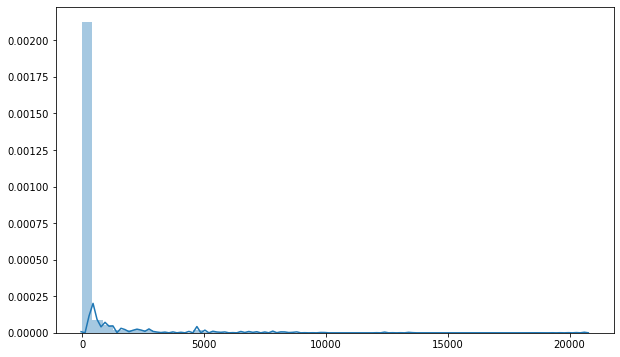

In [11]:
plt.figure(figsize=(10,6))

sns.distplot(no_of_ratings);

In [12]:
no_of_ratings.describe()

,no_of_ratings
count,1674.00000
mean,343.64994
std,1253.72954
min,1.00000
25%,7.00000
50%,26.00000
75%,108.00000
max,20716.00000


We can see that there are many ingredients that have very few reviews while there is an ingredient that has 20.716 reviews. In the following graph we'll try to decide thich is the minimum reviews that an ingredient should have to continue with the model. We will try to build the model with a **min_threshold of 100**.

In [13]:
min_threshold = 100

no_of_ratings_subset = no_of_ratings[no_of_ratings['no_of_ratings'] > min_threshold]
                                     

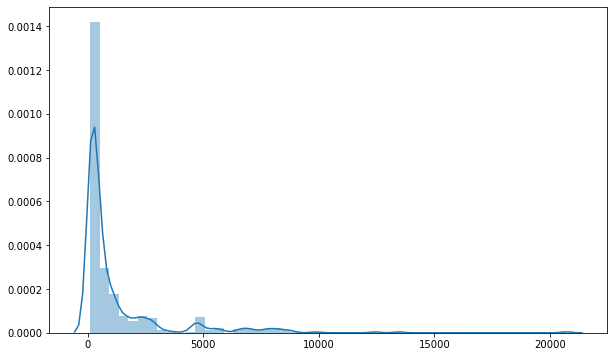

In [14]:
plt.figure(figsize=(10,6))

sns.distplot(no_of_ratings_subset);

### 3.2 Prepare the subset for the model
Now that we know with the ingredients that we will keep for the model, we can prepare the dataset for the model. 

In [15]:
# Group subset by ingredient and avegage in case that a user rated an ingredient more than once
# subset = subset.groupby('ingredients').agg({'mean'})
# subset.reset_index(inplace=True)

In [16]:
subset.head()

,user_id,rating,ingredients
0,8542392,5,pork belly
0,8542392,5,smoked paprika
0,8542392,5,kosher salt
0,8542392,5,ground black pepper
1,11174581,5,pork belly


In [17]:
# Merge with number of ratings
subset_ml = pd.merge(subset, no_of_ratings, how='left', on='ingredients')
subset_ml.reset_index(drop=True, inplace=True)

In [18]:
subset_ml.head()

,user_id,rating,ingredients,no_of_ratings
0,8542392,5,pork belly,3
1,8542392,5,smoked paprika,8
2,8542392,5,kosher salt,234
3,8542392,5,ground black pepper,13456
4,11174581,5,pork belly,3


In [37]:
# Drop ingredients with less than min_threshold
final_ingredients = subset_ml[subset_ml['no_of_ratings'] >= min_threshold]

# Reset index
final_ingredients.reset_index(drop=True, inplace=True)

In [38]:
final_ingredients.shape

(547439, 4)

In [39]:
final_ingredients.head()

,user_id,rating,ingredients,no_of_ratings
0,8542392,5,kosher salt,234
1,8542392,5,ground black pepper,13456
2,11174581,5,kosher salt,234
3,11174581,5,ground black pepper,13456
4,8262477,5,kosher salt,234


### 2.3 Create feature set


In [23]:
# Pivot tables
ingredient_features = final_ingredients.pivot_table(index="ingredients",
                                          columns="user_id",
                                          values="rating").fillna(0)

In [43]:
print(f"Number of ingredients: {ingredient_features.shape[0]}")
print(f"Number of users: {ingredient_features.shape[1]}")

Number of ingredients: 439
Number of users: 42478


**¿?** ASK if I should subset and only get those users that have lots of different reviews.

In [25]:
ingredient_features.head(10)

user_id,39,148,240,338,424,521,650,909,1034,1194,...,23321072,23325694,23330401,23338764,23355167,23357046,23375614,23384227,23389673,23412582
ingredients,,,,,,,,,,,,,,,,,,,,,
Alfredo sauce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
American cheese,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Asian chile pepper sauce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Cajun seasoning,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Chinese five-spice powder,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
Delmonico (rib-eye) steaks,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Dijon mustard,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0
For the glaze:,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
French style green beans,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 3. Modelling

In [44]:
from scipy.sparse import csr_matrix

In [45]:
mat_ingredient_features = csr_matrix(ingredient_features)

### 3.1 Train KNN (K-Nearest-Neighbors)

In [46]:
from sklearn.neighbors import NearestNeighbors

In [47]:
model_knn = NearestNeighbors(metric="cosine",
                             algorithm="brute",
                             n_jobs=-1)
model_knn.fit(mat_ingredient_features)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=5, p=2, radius=1.0)

In [31]:
# DO NOT UNDERSTAND THIS STEP
#with open("final-project/model_knn.pkl", "wb") as mk:
#    pickle.dump(model_knn, mk, protocol=pickle.HIGHEST_PROTOCOL)

In [48]:
ingredient_features.loc['Dijon mustard'].values.reshape(1, -1)

array([[0., 0., 0., ..., 0., 5., 0.]])

In [49]:
model_knn.kneighbors(ingredient_features.loc['Dijon mustard'].values.reshape(1, -1), n_neighbors=5)

(array([[0.        , 0.44646757, 0.44745625, 0.44745625, 0.44774947]]),
 array([[  6, 306, 370,  14, 332]]))

In [50]:
ingredient_features.iloc[6]

user_id
39          0.0
148         0.0
240         0.0
338         0.0
424         0.0
           ... 
23357046    0.0
23375614    0.0
23384227    0.0
23389673    5.0
23412582    0.0
Name: Dijon mustard, Length: 42478, dtype: float64

In [51]:
final_ingredients[final_ingredients["index"] == 6]

KeyError: 'index'

Our kNN model returns a tuple of two 2d-arrays, containing distances and indeces of the nearest neighbors of the vector passed. In order for us to match the results with movieIds or Titles, we need to translate the output.

## Make recommender more user friendly

### #. Possible analysis
- Which are the 25 recipes with more reviews
- Is there a correlation between number of reviews and score. Hyphotesis, the higher the number of reviews the higher the score?
- Is there any correlation between the number of ingredients of a recipe and the rating/number of reciews?